In [20]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [21]:
big = (20,20)
mid = (15,15)
small = (10,10)

In [22]:
def plotImage(img, size=(5, 5), title='window'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap='gray')

def showImage(img, title=''):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def compareTwoImages(a, b, size=(10, 10)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)
    ax[0].imshow(a, cmap='gray')
    ax[1].imshow(b, cmap='gray')
    plt.show()


def plotHistogram(src):
    val, count = np.unique(src, return_counts=True)
    plt.plot(val, count)
    plt.show()

In [23]:
def applyWindow(src, start, end=None, stick=True, dtype=None):
    if dtype is None:
        dtype = src.dtype
    currWindowWidth = np.iinfo(dtype).max + 1
    if end is None:
        end = np.max(src)
    newWindowWidth = end - start + 1
    widthMultiplier = currWindowWidth/newWindowWidth
    dst = src.astype('float128')
    dst[dst < start] = start
    dst[dst > end] = end if stick else start
    dst -= start
    dst *= widthMultiplier
    return dst.astype(src.dtype)


def applyBandpassFilter(src, start, end=None, plot=False):
    if end is None:
        end = np.max(src)
    whitePixelValue = np.iinfo(src.dtype).max
    dst = src.copy()
    dst[(src < start) | (src > end)] = 0
    dst[(start <= src) & (src <= end)] = whitePixelValue
    if plot:
        compareTwoImages(src, dst)
    return dst


def changeImgBitDepth(src, currDepth=12):
    if currDepth is None:
        currWindowWidth = np.iinfo(src.dtype).max+1
    else:
        currWindowWidth = 1 << currDepth
    newDepth = 8
    newWindowWidth = 1 << newDepth
    widthMultiplier = newWindowWidth/currWindowWidth
    dst = src.astype(np.float128)
    def valueAdjust(value): return np.uint8(value*widthMultiplier)
    dst = valueAdjust(dst).astype(np.uint8)
    return dst


def getImgFromDicom(dicomFile):
    BEGIN_USEFUL_WINDOW, END_USEFUL_WINDOW = 944, 1200
    img = dicomFile.pixel_array
    return changeImgBitDepth(applyWindow(img, BEGIN_USEFUL_WINDOW, END_USEFUL_WINDOW, dtype=np.uint8), 8)


def getElement(element=cv2.MORPH_RECT, size=(3, 3)):
    return cv2.getStructuringElement(element, size)

In [24]:
# load the DICOM files
dcm_path = './dicom-files/arq3/pt2'

files = []

for f in os.listdir(dcm_path):
    filename = os.path.join(dcm_path, f)
    if filename[-3:] == 'dcm':
        files.append(pydicom.dcmread(filename))

# skip files with no SliceLocation (eg scout views)

slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

slices = list(map(getImgFromDicom, sorted(slices, key=lambda s: s.SliceLocation)))

/home/rafael/.asdf/installs/python/3.11.3/lib/python3.11/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (11-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


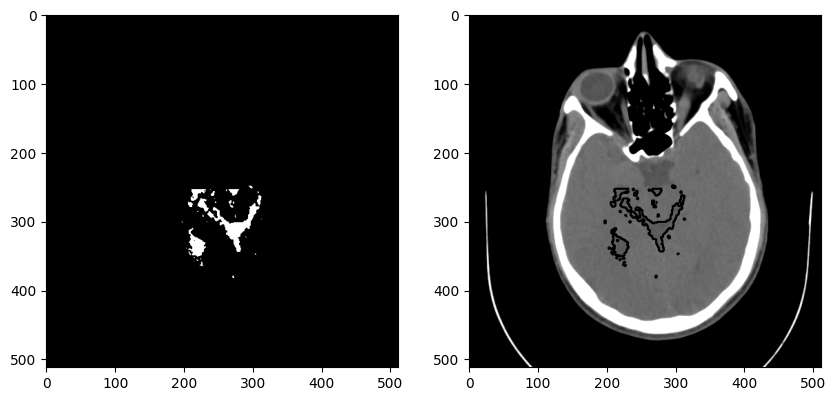

In [25]:
def drawContour(img, mask):
    edges =  cv2.Canny(mask, 85, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.INTERSECT_FULL)
    contour_image = cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    return contour_image

def identifyVentricle(original):
    BEGIN_BONE_WINDOW, END_BONE_WINDOW = 220, 256
    boneMask = applyBandpassFilter(original, BEGIN_BONE_WINDOW, END_BONE_WINDOW)
    maskToRemoveBone = cv2.erode(cv2.bitwise_not(boneMask), getElement(cv2.MORPH_RECT), iterations=40)

    BEGIN_VENTRICLE_WINDOW, END_VENTRICLE_WINDOW = 70, 100
    rawVentricleMask = applyBandpassFilter(original, BEGIN_VENTRICLE_WINDOW, END_VENTRICLE_WINDOW)
    rawVentricleMaskWithoutBone = cv2.bitwise_and(rawVentricleMask, maskToRemoveBone)
    areaOfInterest = cv2.erode(rawVentricleMaskWithoutBone, getElement(cv2.MORPH_RECT, (3,3)), iterations=3)
    areaOfInterest = cv2.dilate(areaOfInterest, getElement(cv2.MORPH_CROSS, (7,7)), iterations=20)
    ventricleMask = cv2.bitwise_and(rawVentricleMaskWithoutBone, areaOfInterest)
    return ventricleMask

original = slices[130]
mask = identifyVentricle(original)
contour_image = drawContour(original.copy(), mask)
compareTwoImages(mask, contour_image)

In [26]:
vertex = []
for Z in range(65,135):
    mask = identifyVentricle(slices[Z])
    mask = cv2.blur(mask, (5, 5))
#    showImage(mask, f'mask{Z}')    
    # edges =  cv2.Canny(mask, 85, 200)
    points = mask
#    showImage(edges, f'edges{Z}')    
    for X in range(len(points)):
        for Y in range(len(points[X])):
                if points[X][Y] == 255:
                    vertex.append((X,Y, 5*Z))
vertex = np.array(vertex)
x = vertex[:, 0]
y = vertex[:, 1]
z = vertex[:, 2]
len(z)

32657

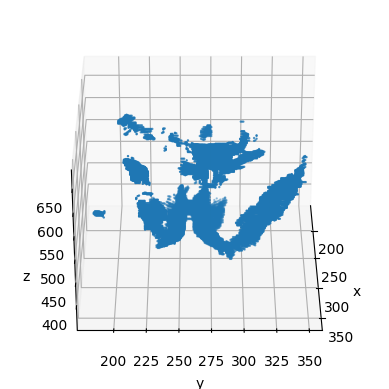

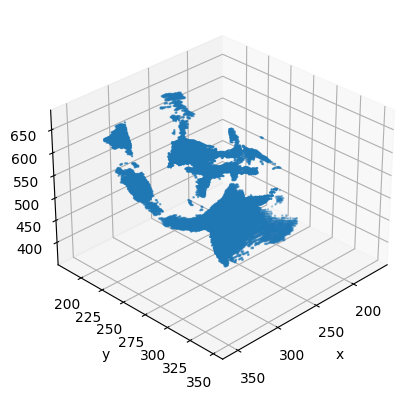

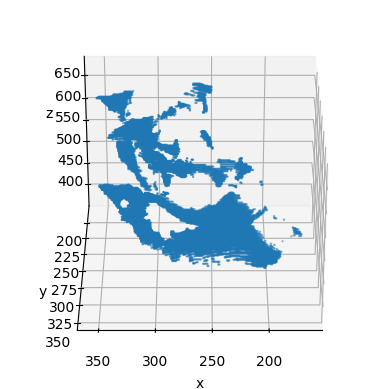

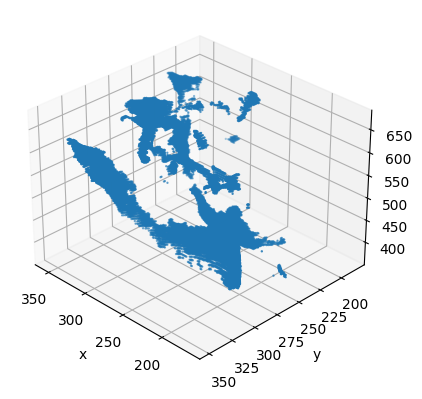

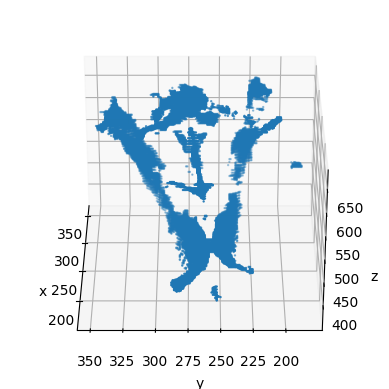

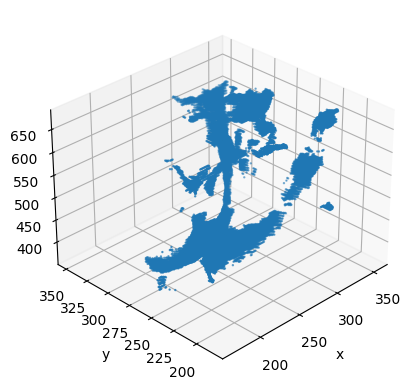

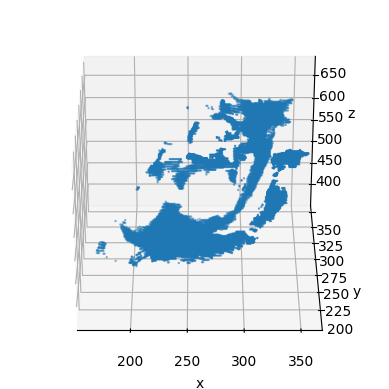

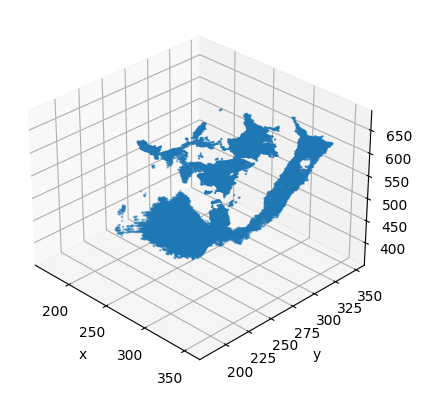

In [39]:
fig = plt.figure()
for i in  range(0, 360, 45):
    ax = plt.axes(projection='3d')
    ax.view_init(azim=i)
    ax.scatter(x, y, z, s=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()